In [653]:
import matplotlib.pyplot as plt
import numpy as np

from utils import *

# Задание 1

In [654]:
handler = Signal_Handler()
converter = Converter(T = 2)
display = Signal_Display(5)

In [655]:
def nonlinear_kernel(x, A):
    return A * np.exp(-x ** 2)

In [656]:
def linear_kernel(x, k, b):
    return k * x + b

In [657]:
x, y, dt      = handler.make_signal('rect',  interval = (-4, 4), A = 1, w = converter.w)
x_k1, y_k1, _ = handler.make_signal('other', interval = (-4, 4), func = lambda x: nonlinear_kernel(x, A = 2))
x_k2, y_k2, _ = handler.make_signal('other', interval = (-4, 4), func = lambda x: linear_kernel(x, k = 2, b = 3))

In [658]:
y_conv1 = np.convolve(y, y_k1, mode = 'same') / np.sum(y_k1)
y_conv2 = np.convolve(y, y_k2, mode = 'same') / np.sum(y_k2)

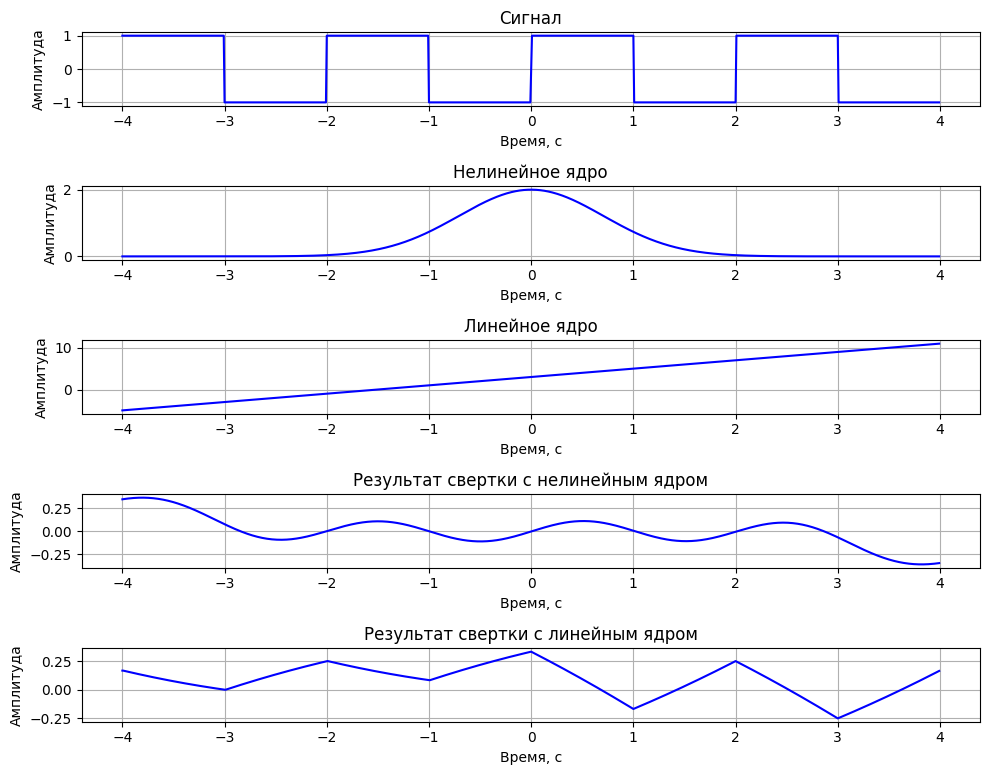

In [659]:
display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k1, y_k1, title = 'Нелинейное ядро')
display.make_plot(2, x_k2, y_k2, title = 'Линейное ядро')
display.make_plot(3, x, y_conv1, title = 'Результат свертки с нелинейным ядром')
display.make_plot(4, x, y_conv2, title = 'Результат свертки с линейным ядром')

display.plot()

# Задание 2

In [660]:
def conv(signal, kernel, mode = 'full'):
    
    res_len = {'full': len(signal) + len(kernel) - 1,
               'same': max(len(signal), len(kernel)),
               'valid': max(len(signal), len(kernel)) - min(len(signal), len(kernel)) + 1}

    conv_res = np.array([
        np.dot(signal[max(0, i) : min(i + len(kernel), len(signal))],
               kernel[max(-i, 0) : len(signal) - i * (len(signal) - len(kernel) < i)]) 
               for i in range(1 - len(kernel), len(signal))
               ])

    if mode == 'full':
        return conv_res
    
    if mode in ['same', 'valid']:
        start_index = int(np.floor((res_len['full'] - res_len[mode]) / 2))
        return conv_res[start_index : start_index + res_len[mode]]

In [661]:
y_conv = conv(y, y_k1, mode = 'same') / np.sum(y_k1)

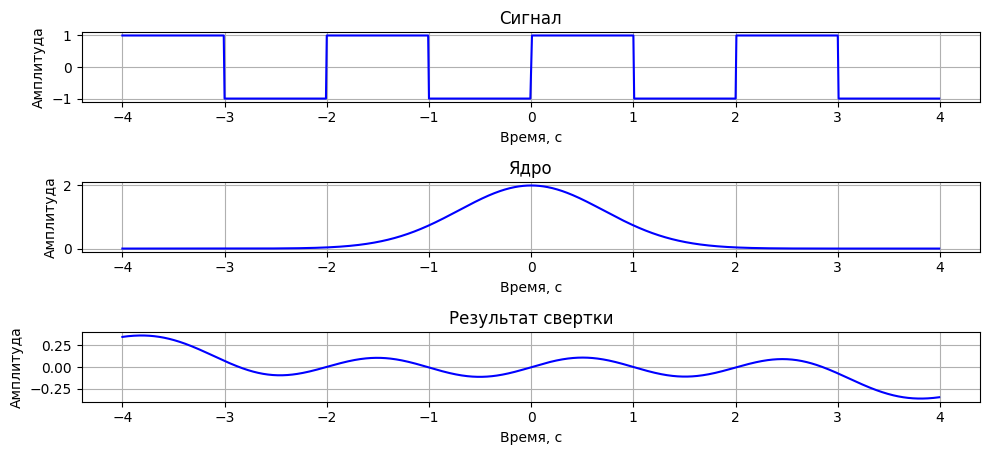

In [662]:
display.clear(3)

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k1, y_k1, title = 'Ядро')
display.make_plot(2, x, y_conv, title = 'Результат свертки')

display.plot()

# Задание 3

In [663]:
def fft_conv(signal, kernel, mode = 'full'):
    handler = Signal_Handler()

    res_len = {'full': len(signal) + len(kernel) - 1,
               'same': max(len(signal), len(kernel)),
               'valid': max(len(signal), len(kernel)) - min(len(signal), len(kernel)) + 1}

    signal = np.pad(signal, (0, res_len['full'] - len(signal)), 'constant')
    kernel = np.pad(kernel, (0, res_len['full'] - len(kernel)), 'constant')
        
    _, yf_s = handler.find_spectrum(signal, 1)
    _, yf_k = handler.find_spectrum(kernel, 1)

    conv_res = ifft(yf_s * yf_k)

    if mode == 'full':
        return conv_res
    
    if mode in ['same', 'valid']:
        start_index = int(np.floor((res_len['full'] - res_len[mode]) / 2))
        return conv_res[start_index : start_index + res_len[mode]]

In [664]:
y_conv = fft_conv(y, y_k1, mode = 'same') / np.sum(y_k1)

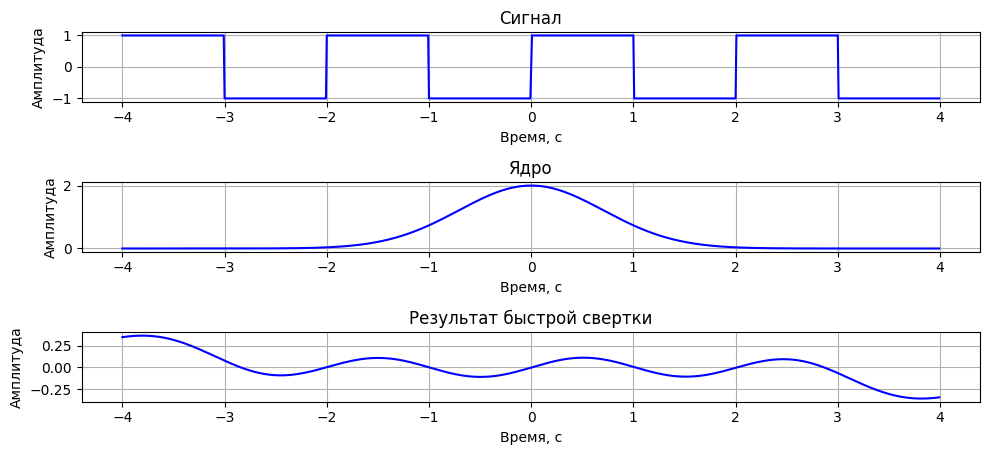

In [665]:
display.clear(3)

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k1, y_k1, title = 'Ядро')
display.make_plot(2, x, y_conv, title = 'Результат быстрой свертки')

display.plot()

# Задание 4

In [666]:
def Gaussian_kernel(x, p, FWHM):
    s = FWHM * (2 * np.pi - 1) / (4 * np.pi)
    return np.exp(-0.5 * ((x - p) / s) ** 2)

In [667]:
x_k, y_k, _ = handler.make_signal('other', interval = (0, 10), func = lambda X: Gaussian_kernel(X, p = 5, FWHM = 1))

In [668]:
y_conv = np.convolve(y, y_k, mode = 'same') / np.sum(y_k)

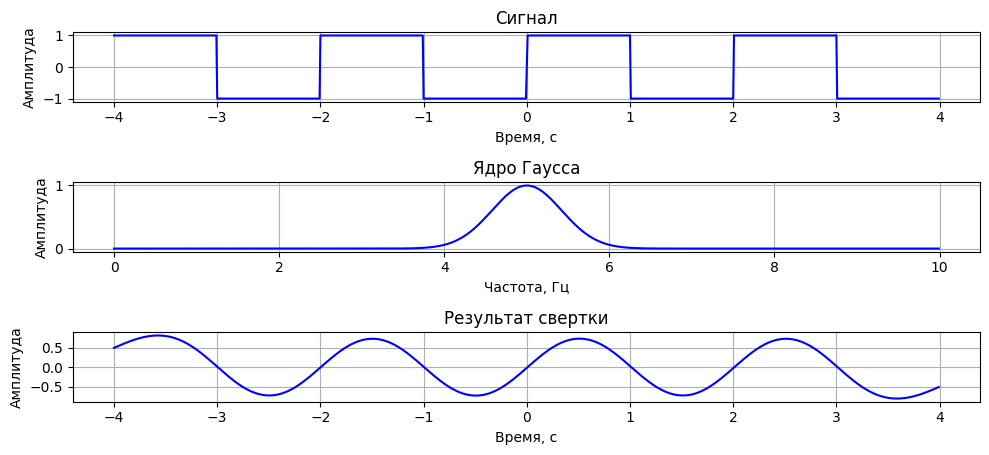

In [669]:
display.clear(3)

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k, y_k, title = 'Ядро Гаусса', is_spectrum = True, normalize = False)
display.make_plot(2, x, y_conv, title = 'Результат свертки')

display.plot()

# Задание 5

In [670]:
def pad_signal(xfft, y_k, interval):
    ids = np.logical_and(xfft >= interval[0], xfft < interval[1])

    yfft = np.zeros_like(xfft)
    yfft[ids] = y_k

    return yfft

### Свертка в частотной области

In [671]:
x_k, y_k, _ = handler.make_signal('other', interval = (1, 5), sample_rate = int(4 * dt * 1000), func = lambda X: Gaussian_kernel(X, p = 3, FWHM = 1))
x_f, y_f = handler.find_spectrum(y, dt)

In [672]:
yf_k = pad_signal(x_f, y_k, (1, 5))

In [673]:
yf_conv = yf_k * y_f
y_conv = handler.from_spectrum(yf_conv)

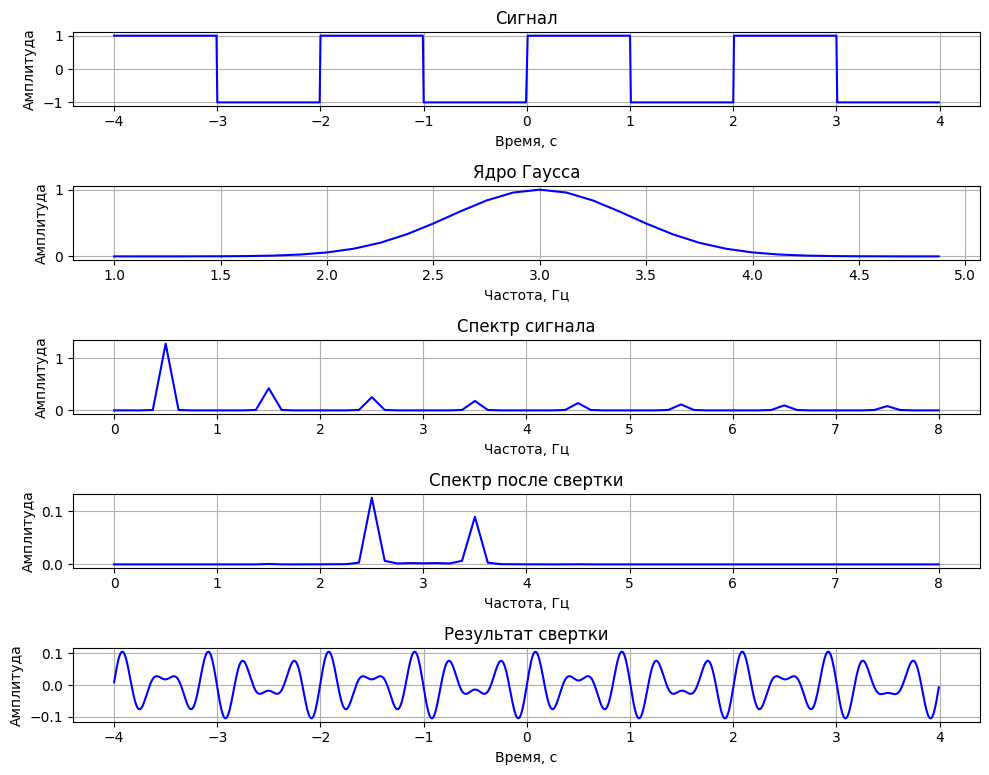

In [674]:
display.clear(5)

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k, y_k, title = 'Ядро Гаусса', is_spectrum = True, normalize = False)
display.make_plot(2, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 8))
display.make_plot(3, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 8))
display.make_plot(4, x, y_conv, title = 'Результат свертки')

display.plot()

### Узкополосный фильтр через свертку

In [675]:
x, y, dt = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 250, 450]).w)
x_k, y_k, _ = handler.make_signal('other', interval = (40, 460), sample_rate = int(420 * dt * 1000), func = lambda X: Gaussian_kernel(X, p = 250, FWHM = 250))

In [676]:
x_f, y_f = handler.find_spectrum(y, dt)

In [677]:
yf_k = pad_signal(x_f, y_k, (40, 450))

In [678]:
yf_conv = yf_k * y_f
y_conv = handler.from_spectrum(yf_conv)

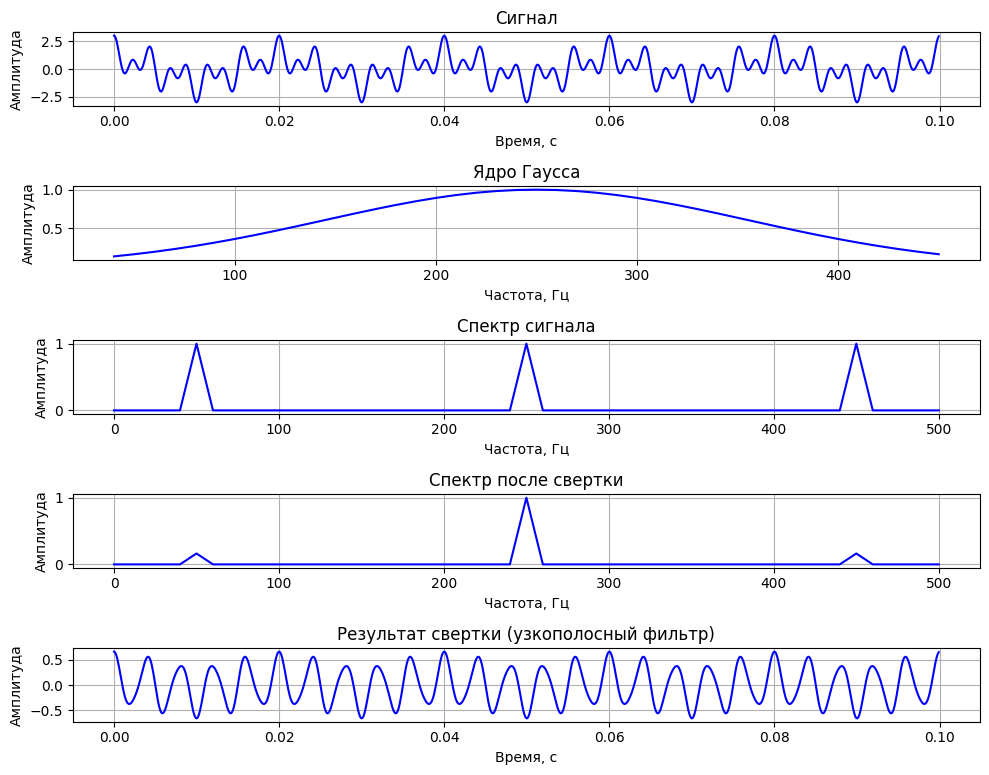

In [679]:
display.clear(5)

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k, y_k, title = 'Ядро Гаусса', is_spectrum = True, normalize = False)
display.make_plot(2, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 500))
display.make_plot(3, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 500))
display.make_plot(4, x, y_conv, title = 'Результат свертки (узкополосный фильтр)')

display.plot()

### ФНЧ через свертку

In [680]:
x, y, dt = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 250, 450]).w)
x_k, y_k, _ = handler.make_signal('other', interval = (0, 400), sample_rate = int(400 * dt * 1000), func = lambda X: Gaussian_kernel(X, p = 150, FWHM = 100))

In [681]:
x_f, y_f = handler.find_spectrum(y, dt)

In [682]:
yf_k = pad_signal(x_f, y_k, (0, 400))

In [683]:
yf_conv = yf_k * y_f
y_conv = handler.from_spectrum(yf_conv)

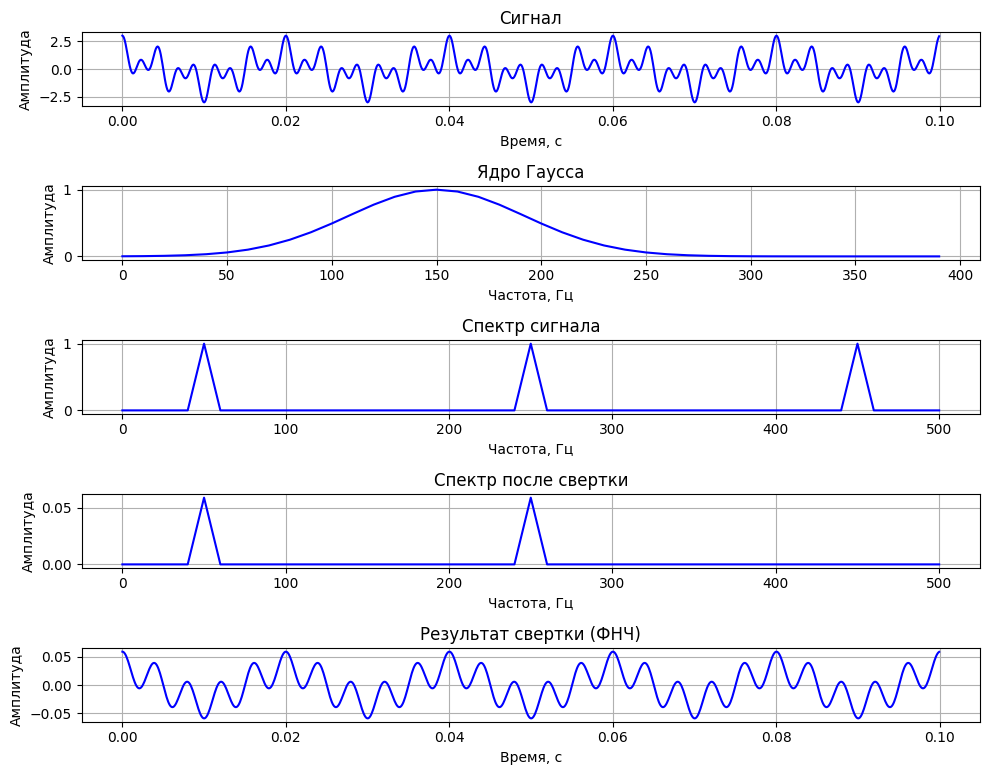

In [684]:
display.clear(5)

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k, y_k, title = 'Ядро Гаусса', is_spectrum = True, normalize = False)
display.make_plot(2, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 500))
display.make_plot(3, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 500))
display.make_plot(4, x, y_conv, title = 'Результат свертки (ФНЧ)')

display.plot()

# Задание 6

In [685]:
def Planck_taper_window(X, eps):

    k = np.arange(X.size)
    N = X.size

    za = lambda t: eps * (N - 1) * (1 / t + 1 / (t - eps * (N - 1)))
    zb = lambda t: eps * (N - 1) * (1 / (N - 1 - t) + 1 / ((1 - eps) * (N - 1) - t))

    mask1 = np.logical_and(k > 0, k < eps * (N - 1))
    mask2 = np.logical_and(k >= eps * (N - 1), k <= (1 - eps) * (N - 1))
    mask3 = np.logical_and(k > (1 - eps) * (N - 1), k < (N - 1))
    mask4 = np.logical_or(k == 0, k == N - 1)

    k[mask1] = 1 / (np.exp(za(k[mask1])) + 1)
    k[mask2] = 1
    k[mask3] = 1 / (np.exp(zb(k[mask1])) + 1)
    k[mask4] = 0

    return k

In [686]:
x, y, dt = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 250, 450]).w)
x_k, y_k, _ = handler.make_signal('other', interval = (200, 300), sample_rate = int(100 * dt * 1000), func = lambda X: Planck_taper_window(X, eps = 0.2))

In [687]:
x_f, y_f = handler.find_spectrum(y, dt)

In [688]:
yf_k = pad_signal(x_f, y_k, (200, 300))

In [689]:
yf_conv = y_f * yf_k
y_conv = handler.from_spectrum(yf_conv)

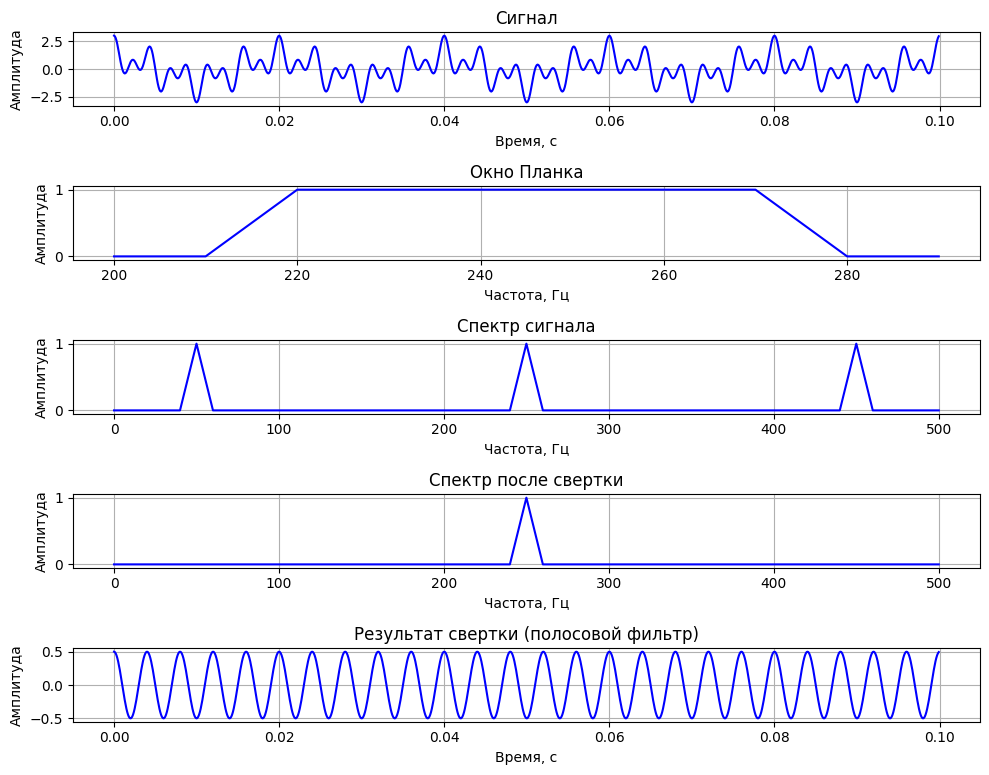

In [690]:
display.clear(5)

display.make_plot(0, x, y, title = 'Сигнал')
display.make_plot(1, x_k, y_k, title = 'Окно Планка', is_spectrum = True, normalize = False)
display.make_plot(2, x_f, y_f, title = 'Спектр сигнала', is_spectrum = True, interval = (0, 500))
display.make_plot(3, x_f, yf_conv, title = 'Спектр после свертки', is_spectrum = True, interval = (0, 500))
display.make_plot(4, x, y_conv, title = 'Результат свертки (полосовой фильтр)')

display.plot()

# Задание 7